In [2]:
%cd /data/gunsbrother/repos/vq2d-lightning
%load_ext autoreload
%autoreload 2

/data/gunsbrother/repos/vq2d-lightning


/home/gunsbrother/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [10]:
from IPython.display import Image as IPImage

from ltvu.lit.model import LitModule
from ltvu.lit.data import LitVQ2DDataModule
from ltvu.dataset.vq2d import VQ2DFitDataset

import decord
import hydra
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf
from diffusers.utils import make_image_grid

import torch
import torchvision.transforms.functional as TF
from einops import rearrange, repeat
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
from pathlib import Path


def ten2pil(tensor, pad: float = 0.02, alpha = None, cmap = 'viridis'):
    assert tensor.dim() in (2, 3)  # (H, W), (C, H, W)
    tensor = tensor.cpu()
    tensor -= tensor.min()
    tensor /= tensor.max()

    if tensor.dim() == 3:
        tensor = tensor.permute(1, 2, 0)
        assert tensor.shape[-1] == 3

    fig = plt.figure(figsize=(5, 5))
    ax = plt.Axes(fig, [pad, pad, 1. - 2* pad, 1. - 2 * pad])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(tensor, aspect='equal', alpha=alpha, cmap=cmap)

    plots_io = BytesIO()
    fig.savefig(plots_io, format='jpg' if alpha is None else 'png', bbox_inches='tight', pad_inches=0)
    plt.close()

    img = Image.open(plots_io)
    # plots_io.close()
    return img

GlobalHydra.instance().clear()
OmegaConf.clear_resolvers()
OmegaConf.register_new_resolver("job_type", lambda : 'debug')
OmegaConf.register_new_resolver('runtime_outdir', lambda : 'outputs/tmp')
OmegaConf.register_new_resolver("eval", eval)
OmegaConf.register_new_resolver("tuple", lambda *args: tuple(args))
hydra.initialize(config_path='config', job_name='asdasdasdasdasd')

/tmp/ipykernel_1135457/1637275308.py:54: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path='config', job_name='asdasdasdasdasd')


hydra.initialize()

In [3]:
path_ckpt = 'outputs/batch/2024-09-15/123741/epoch=61-prob_acc=0.7739.ckpt'
plm_base = LitModule.load_from_checkpoint(path_ckpt).cuda()
plm_base.eval()
plm_base.freeze()

path_ckpt = 'outputs/ckpts/34597/epoch=47-prob_acc=0.7977.ckpt'
plm = LitModule.load_from_checkpoint(path_ckpt).cuda()
plm.eval()
plm.freeze()

eval_config = hydra.compose(config_name='eval', overrides=[
    f'ckpt={path_ckpt.replace('=', '\\=')}',
    f'batch_size=1',
    f'num_workers=4',
    f'prefetch_factor=1'
])
pdm = LitVQ2DDataModule(eval_config)  # won't use trainer here nor batched forward pass so no need to load the eval config and plm.config is enough
pdm.batch_size = 1

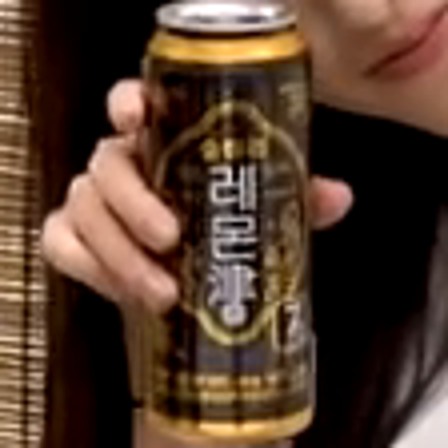

In [27]:
query = Image.open('/data/gunsbrother/prjs/ltvu2/VQLoC/samples/i3jpejz-PPc/query_crop.png')
display(query)
query = TF.to_tensor(query).unsqueeze(0).cuda()

In [ ]:
vr = decord.VideoReader('/data/gunsbrother/prjs/ltvu2/VQLoC/samples/i3jpejz-PPc/[i3jpejz-PPc]-796x448-00:23:27-29.97.mp4')
target_frame = int(837.8*29.97)
ds = VQ2DFitDataset(eval_config)

In [51]:
segments = vr[target_frame:target_frame+6*32:6]
segments = rearrange(segments, 'b h w c -> b c h w') / 255.
segments_padded, _ = ds.pad_and_resize(segments, np.array([[0., 0., 0., 0.]]))
segments_padded = segments_padded.cuda()

In [53]:
with torch.inference_mode():
    input_segments, input_query = pdm.normalize(segments_padded[None], query)
    out = plm.model.forward(
        segment=input_segments,
        query=input_query,
        before_query_mask=torch.randn(1, 32).cuda(),
        gt_probs=torch.randn(1, 32).cuda(),
        gt_bboxes=torch.randn(1, 32, 4).cuda(),
        compute_loss=True, get_intermediate_features=False, training=False)

In [55]:
out['info_dict']['preds_top']['prob'].sigmoid()

tensor([[0.4126, 0.6918, 0.7469, 0.7245, 0.6796, 0.4809, 0.4639, 0.3860, 0.4174,
         0.4409, 0.4519, 0.1208, 0.1764, 0.1028, 0.0905, 0.1076, 0.1160, 0.0767,
         0.1077, 0.0766, 0.0904, 0.0682, 0.0773, 0.1686, 0.2331, 0.2196, 0.3273,
         0.3267, 0.3887, 0.3178, 0.2851, 0.1594]], device='cuda:0')

In [57]:
segments_padded.shape

torch.Size([32, 3, 448, 448])

Text(0, 0.5, 'Prob')

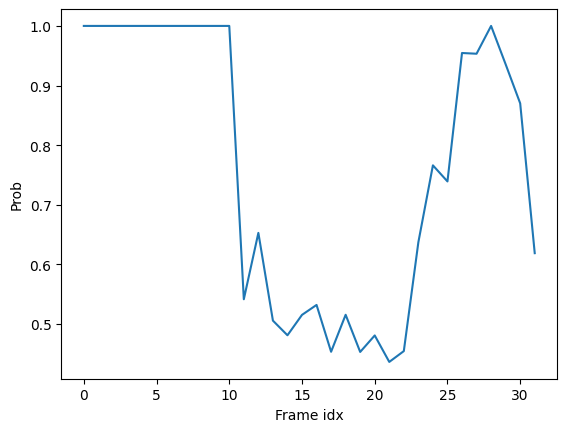

In [68]:
probs = pred_probs[0].cpu().numpy()
probs -= .1
probs *= 2
probs = (probs + .5).clip(0, 1)
plt.plot(probs)
plt.xlabel('Frame idx')
plt.ylabel('Prob')

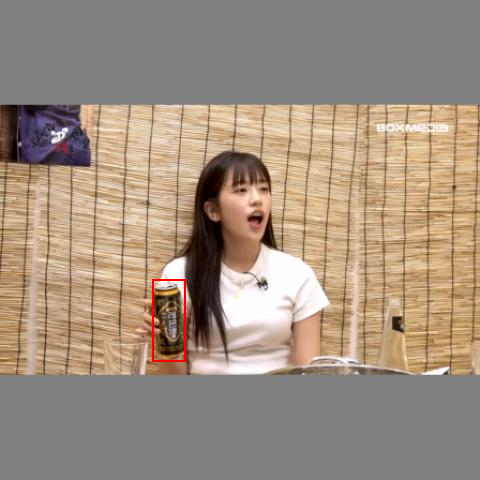

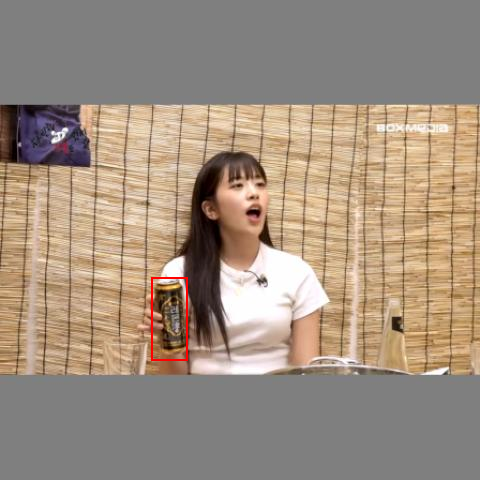

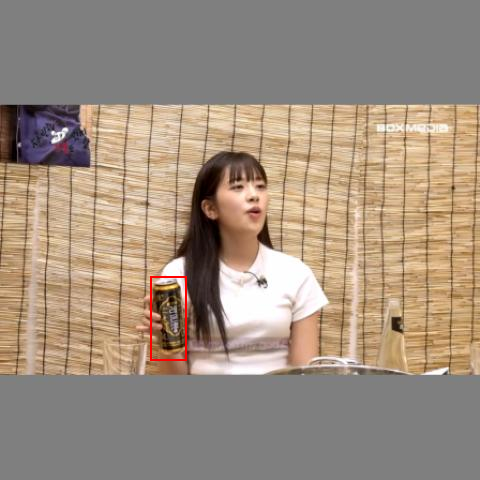

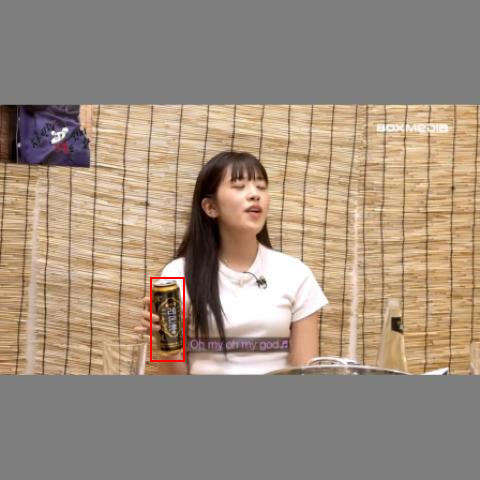

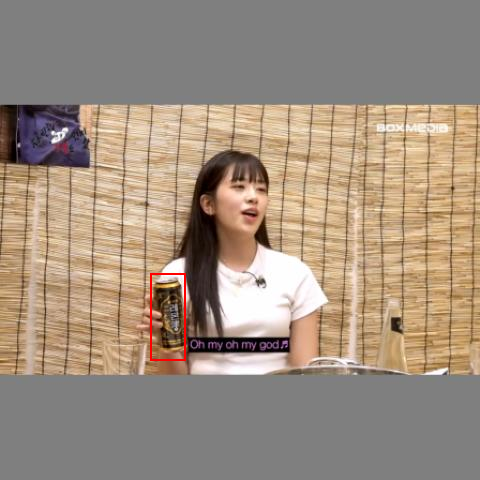

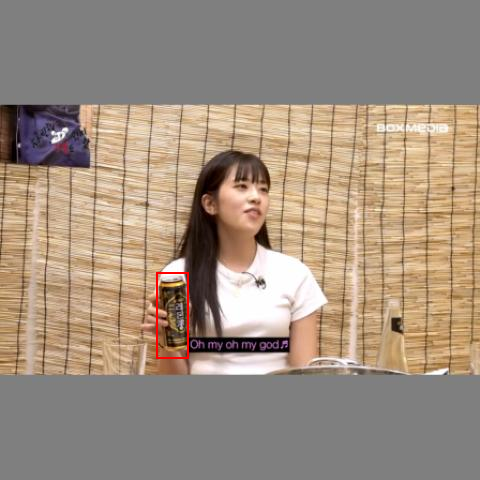

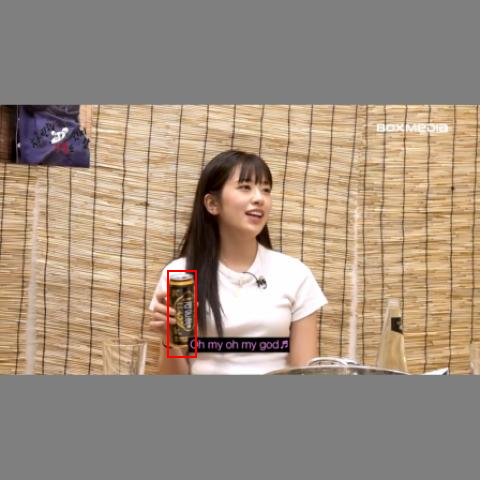

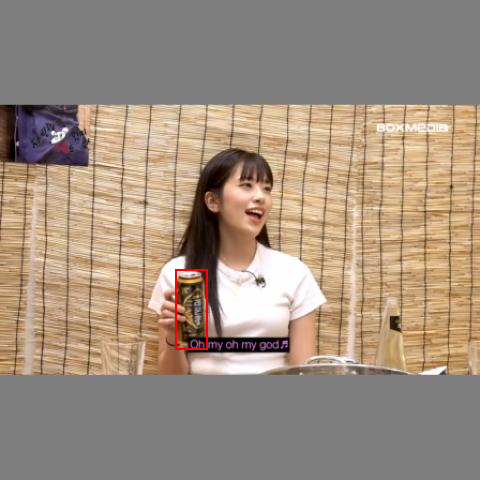

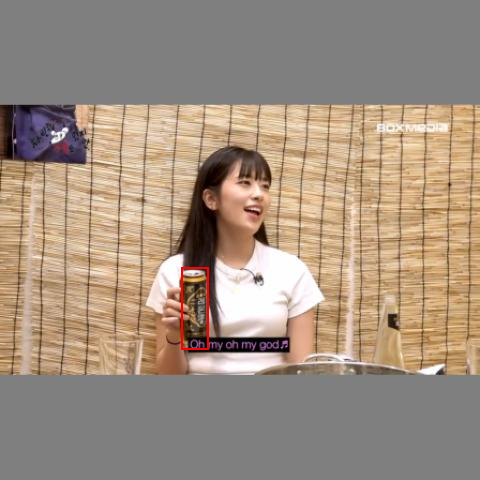

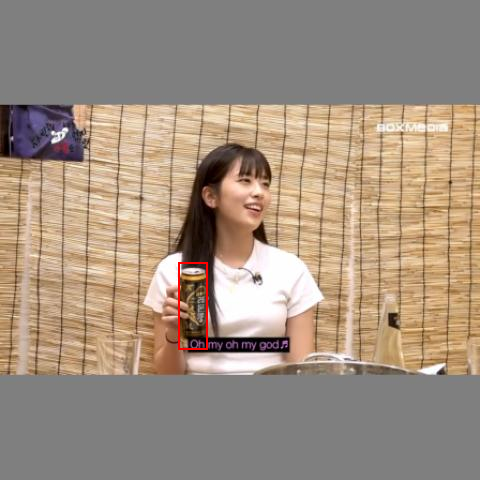

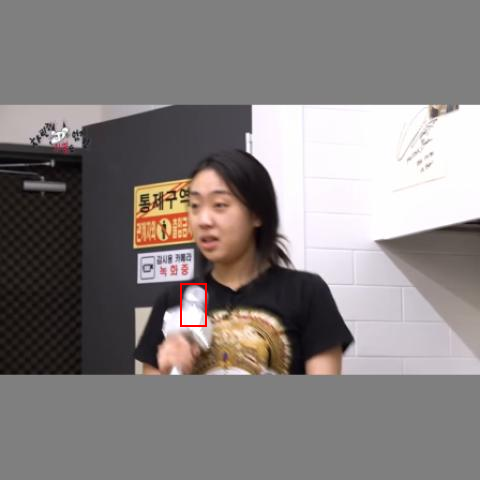

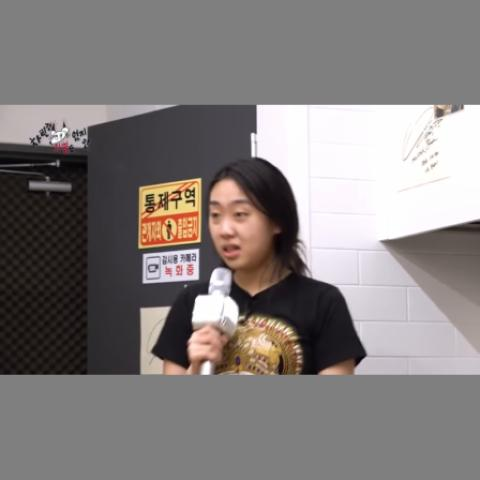

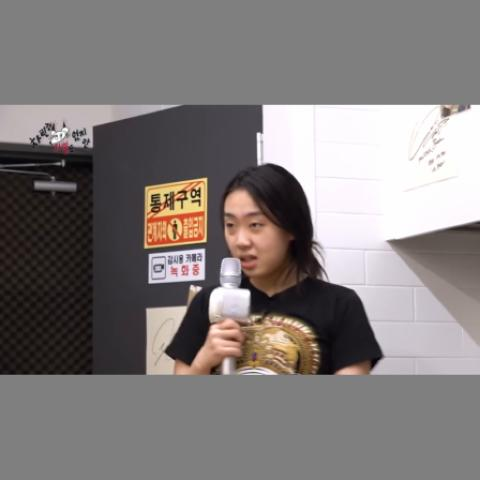

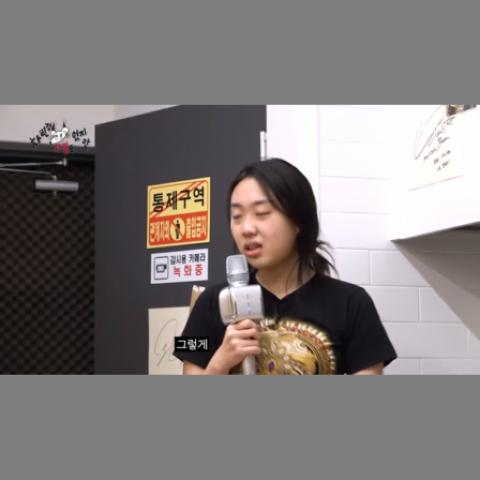

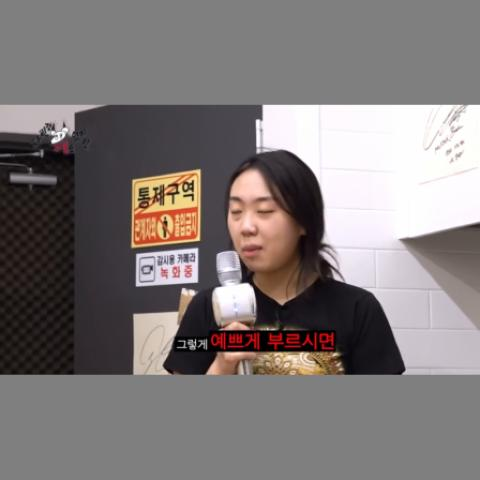

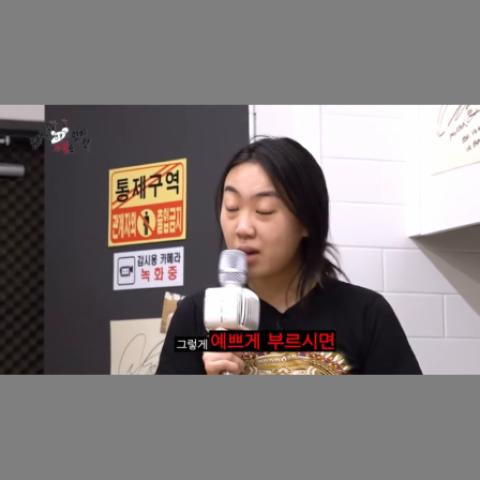

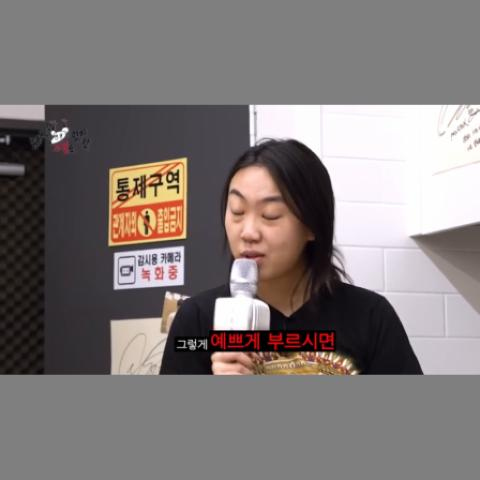

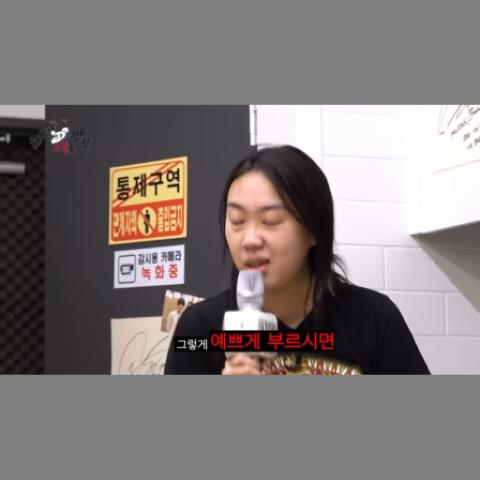

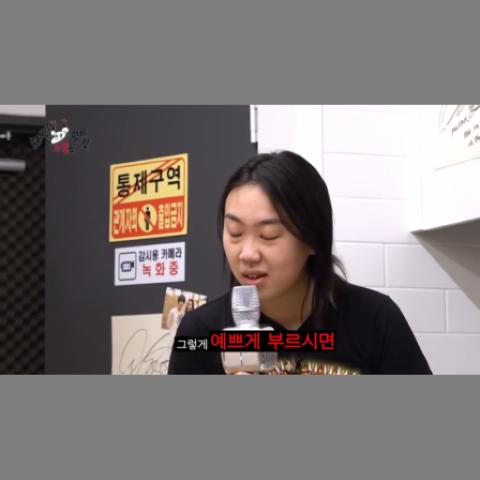

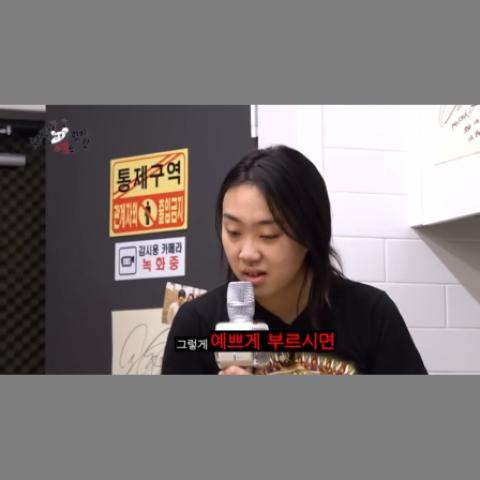

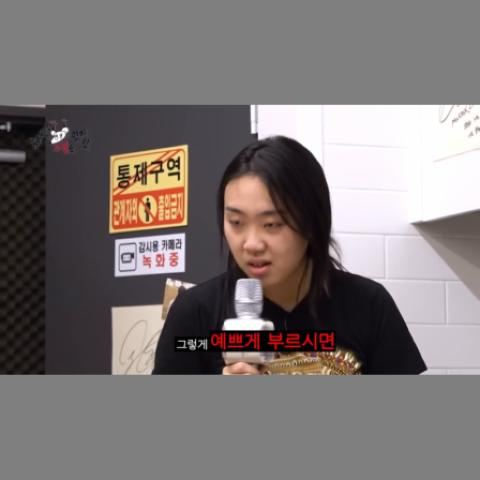

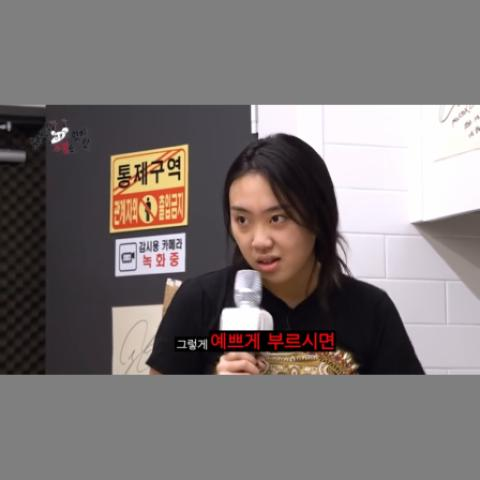

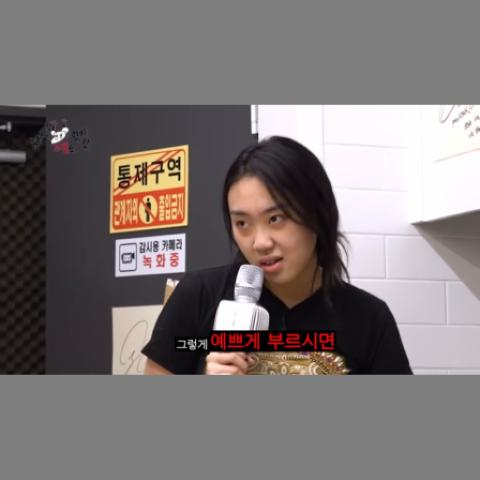

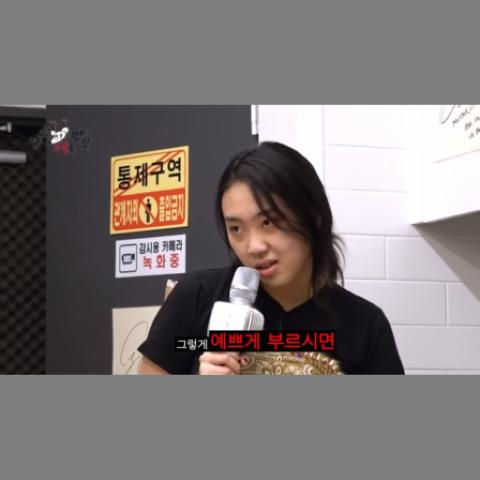

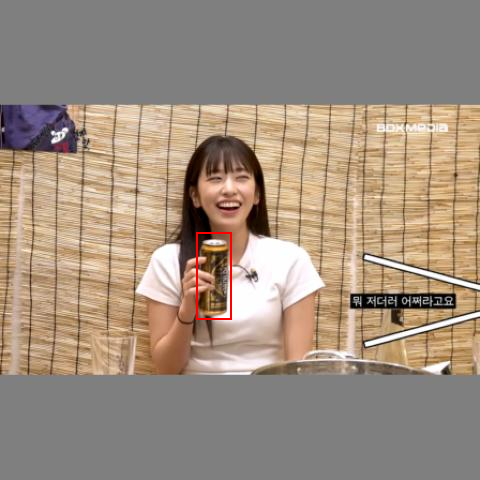

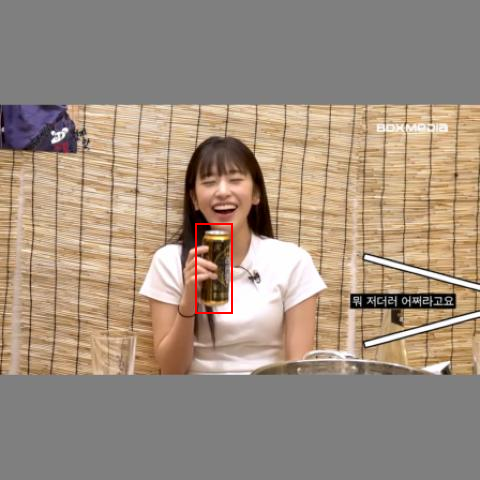

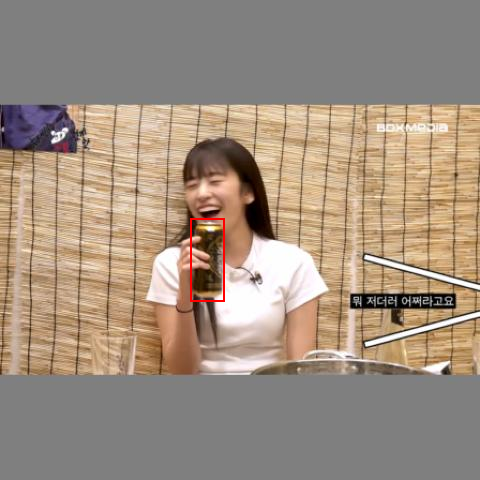

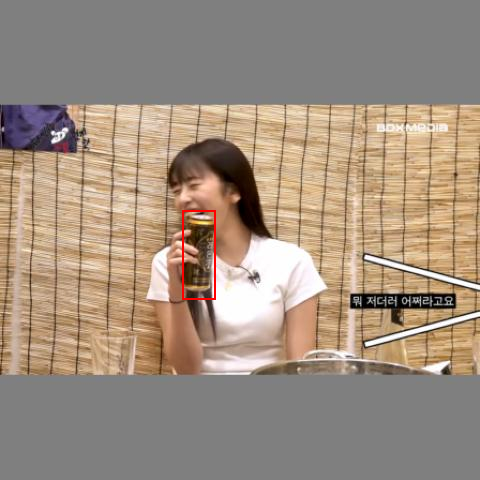

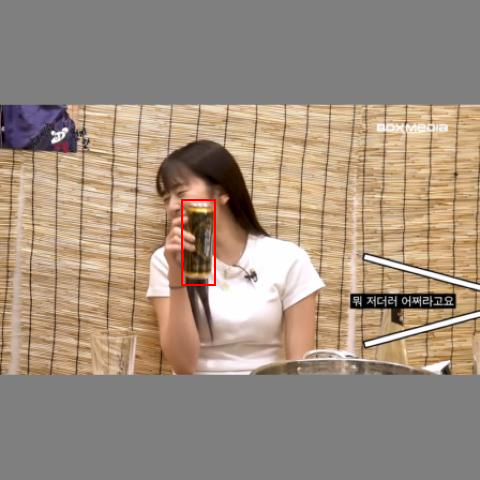

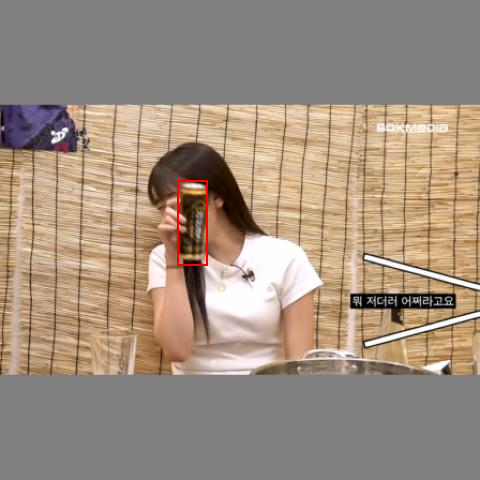

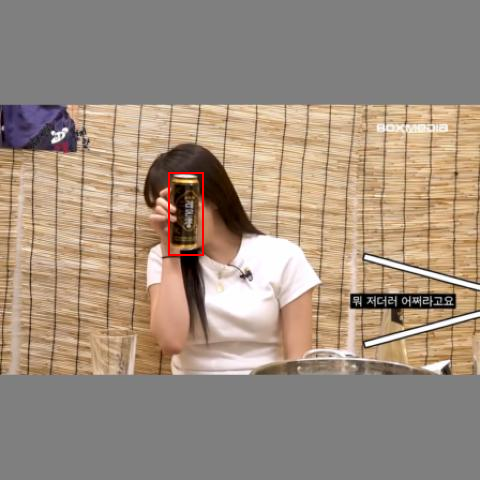

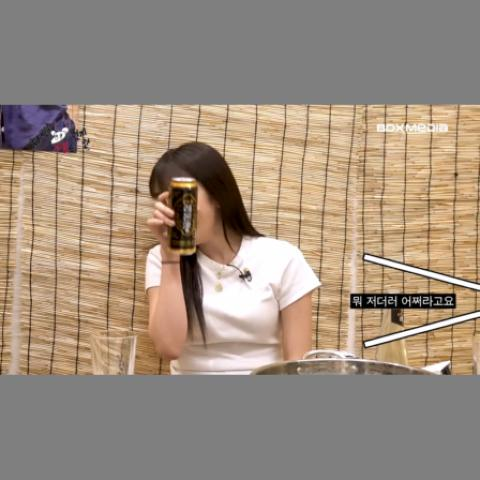

In [60]:
from PIL import ImageDraw


pred_bboxes = out['info_dict']['preds_top']['bbox']
pred_probs = out['info_dict']['preds_top']['prob'].sigmoid()
for fidx in range(32):
    image = ten2pil(segments_padded[fidx]).convert('RGBA')

    py1, px1, py2, px2 = (image.size[0] * pred_bboxes[0, fidx]).cpu().numpy().astype(int)
    if pred_probs[0, fidx] > 0.2:
        draw = ImageDraw.Draw(image)
        draw.rectangle([(px1, py1), (px2, py2)], outline=(255, 0, 0), width=2)
    display(image)